# SHAP Values Analysis

SHAP (SHapley Additive exPlanations) estimates how much each input feature contributes to a prediction by assigning an importance value called a Shapley value. This value shows how much the feature pushes the model’s output away from or toward a baseline (usually the average prediction).

In this notebook, we analyze SHAP values generated for our drug synergy prediction models (Biomining, TranSynergy) using GradientExplainer. K-means sampling was also used to manage large dataset for Transynergy.

The biological analysis will focus on 2 cell lines for each model, shown at the end.


In [7]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [8]:
from explainability.shapley.utils import load_shap_data

bio_shap_values, bio_inputs, bio_feature_names, bio_indices = load_shap_data("biomining")
tran_shap_values, tran_inputs, tran_feature_names, tran_indices = load_shap_data("transynergy")

FileNotFoundError: SHAP complete data file not found: explainability\shapley\results\biomining\shap_complete.npz

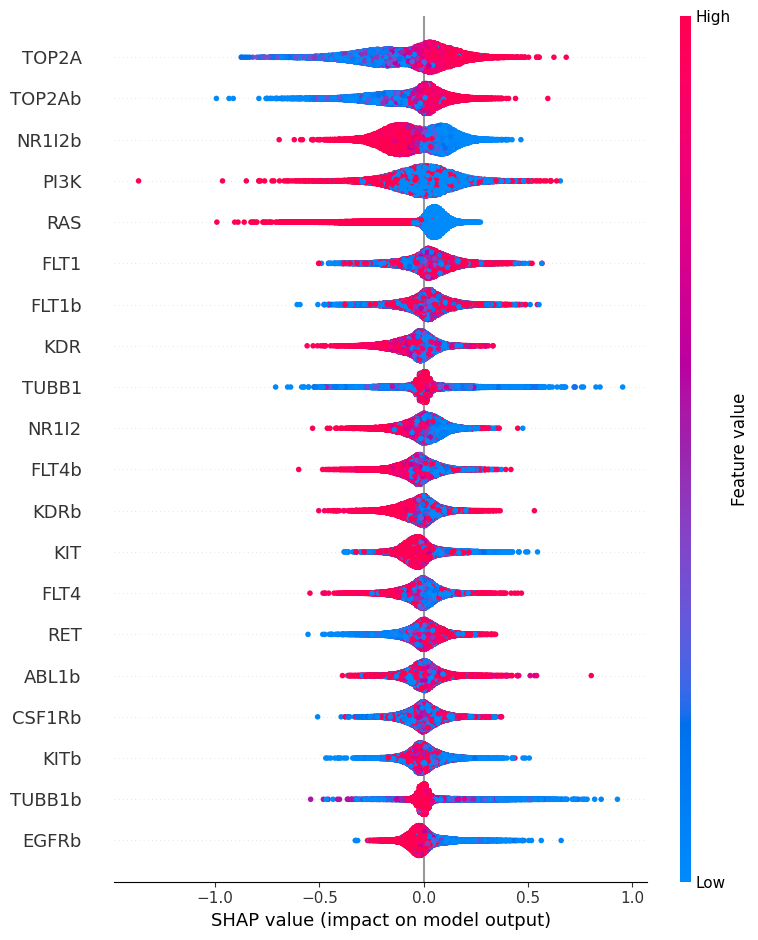

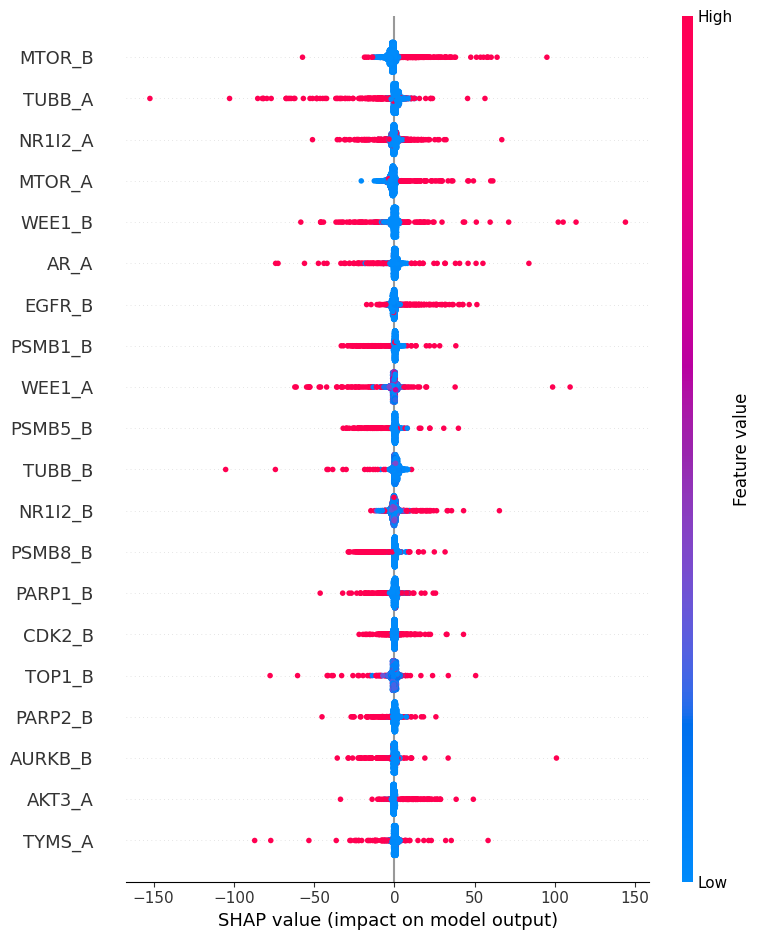

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(bio_shap_values, bio_inputs, bio_feature_names)
shap.summary_plot(tran_shap_values, tran_inputs, tran_feature_names)
plt.show()

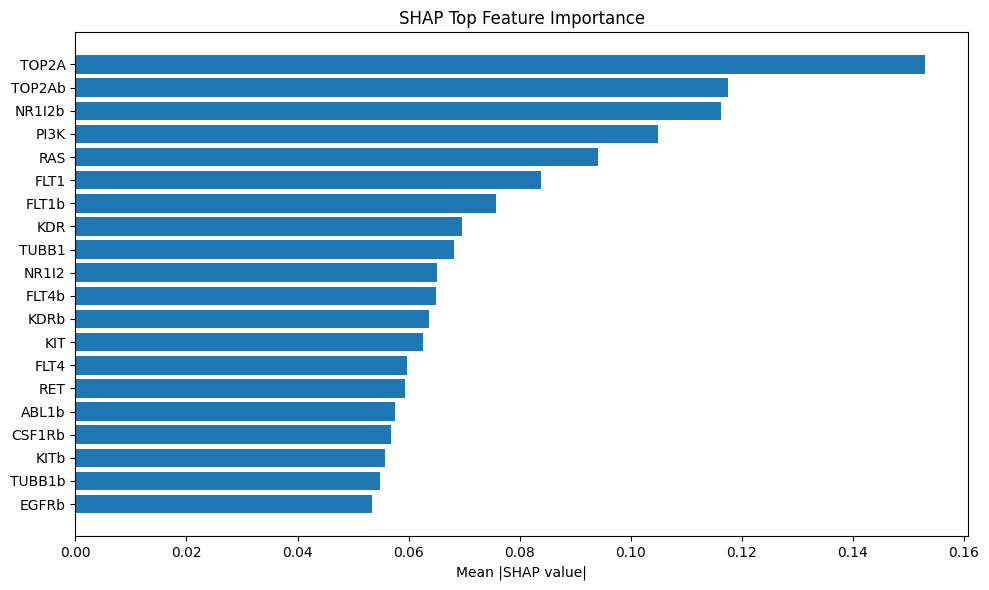

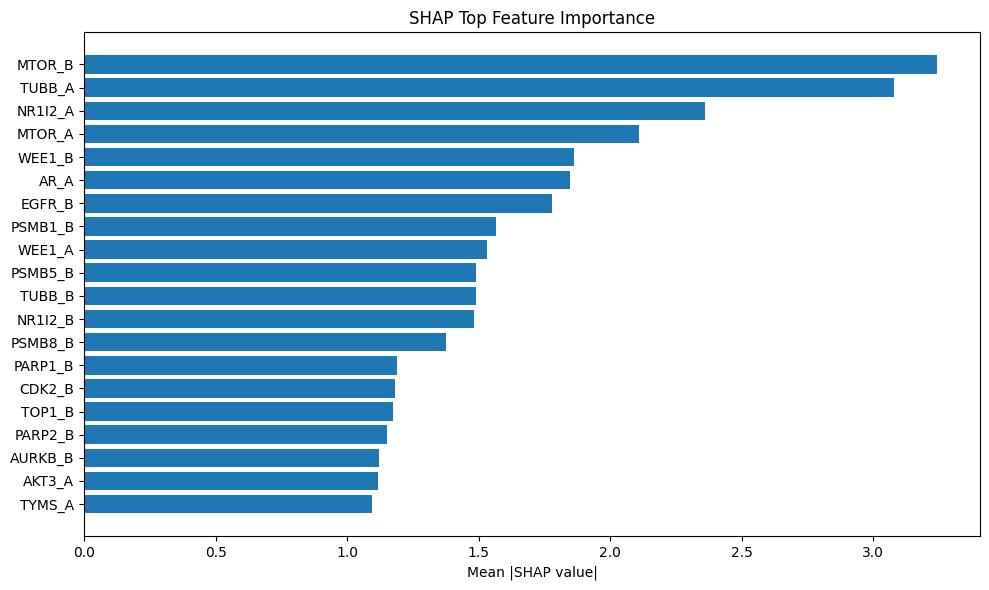

In [ ]:
import numpy as np
import pandas as pd

def plot_feature_importance(shap_values, feature_names, top_n=20):
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
    plt.xlabel("Mean |SHAP value|")
    plt.title("SHAP Top Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(bio_shap_values, bio_feature_names)
plot_feature_importance(tran_shap_values, tran_feature_names)

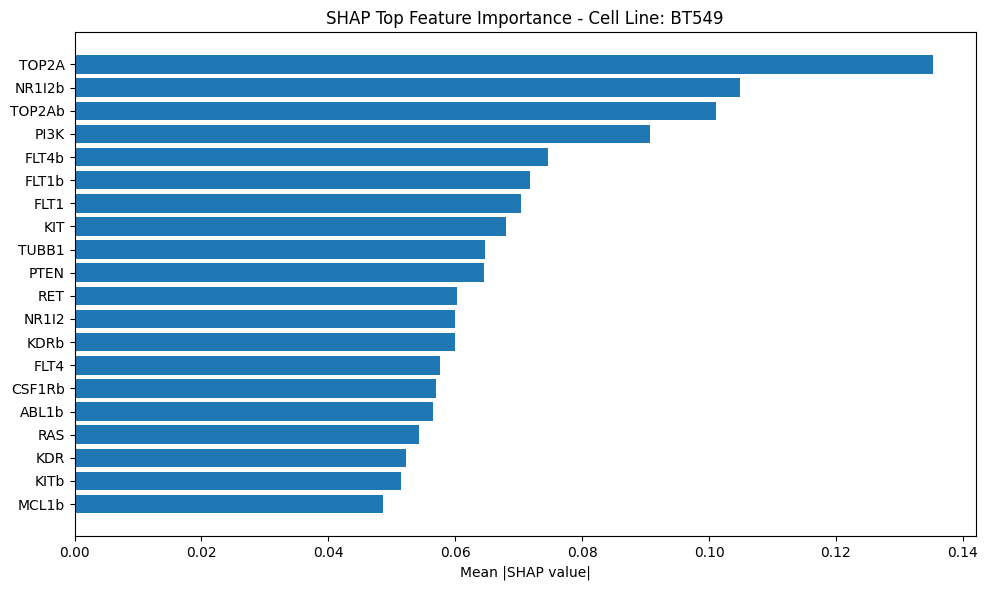

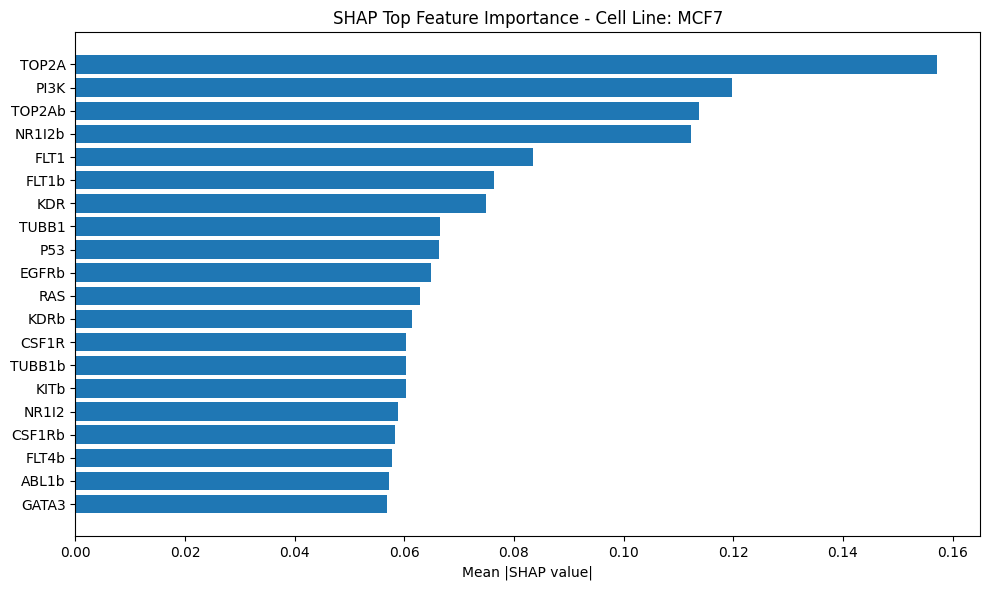

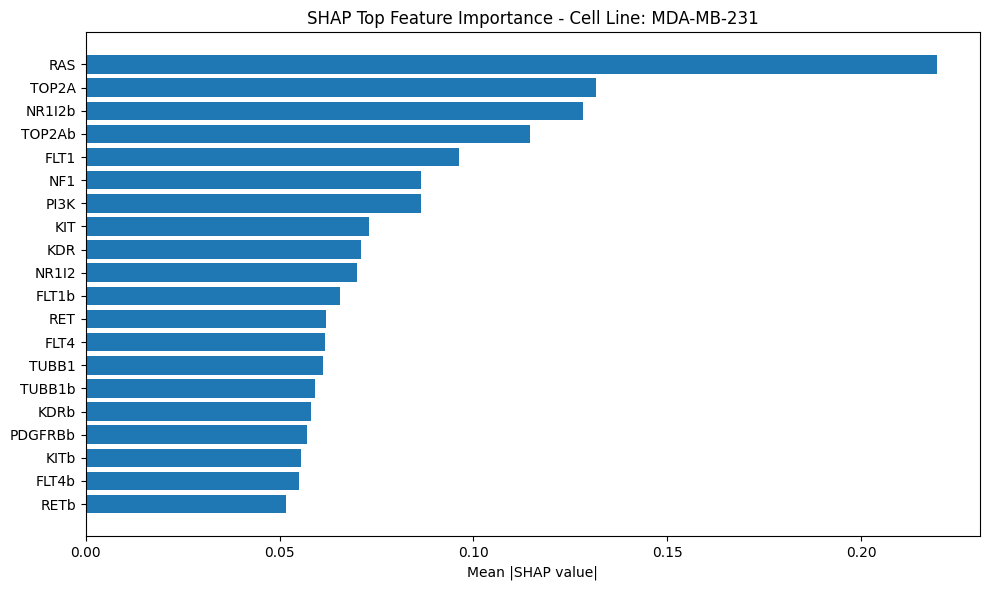

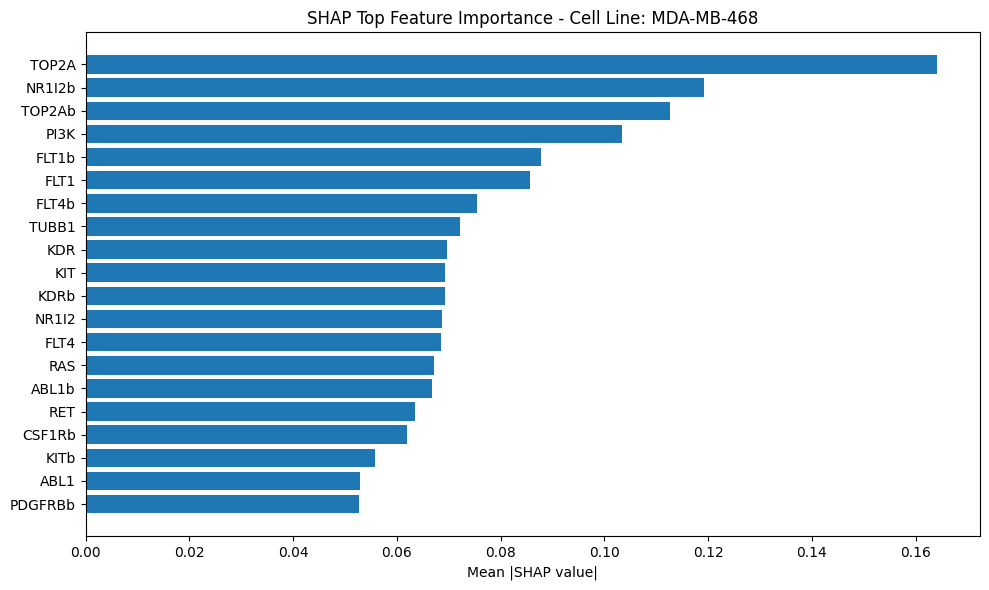

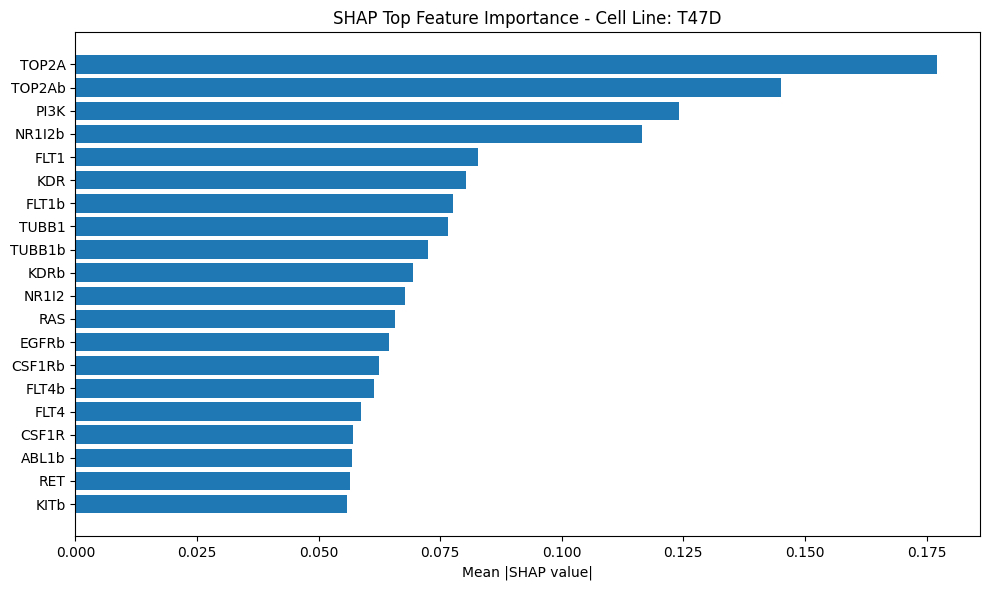

In [ ]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(shap_values, feature_names, bio_indices, top_n=20):
    cell_lines = load_biomining_cell_line_data(split='test')
    #because of permutation
    cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    #only get the cell lines that were used for SHAP
    sampled_cell_lines = cell_lines[bio_indices]
    
    unique_cell_lines = np.unique(sampled_cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(sampled_cell_lines == cell_line)[0]
        cell_line_shap_values = shap_values[cell_line_indices]
        
        mean_abs_shap = np.mean(np.abs(cell_line_shap_values), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs_shap
        }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"SHAP Top Feature Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(bio_shap_values, bio_feature_names, bio_indices)


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


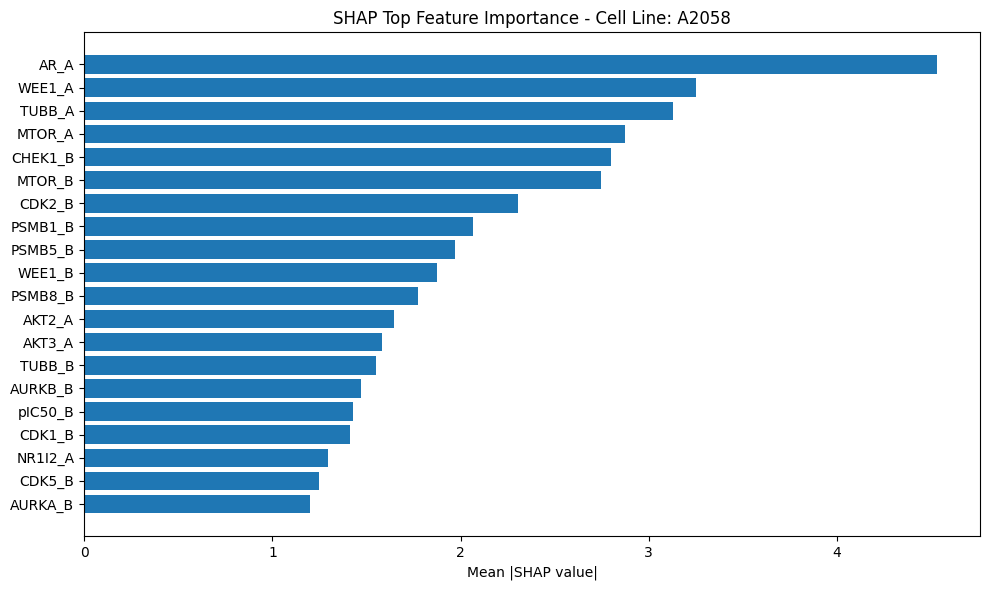

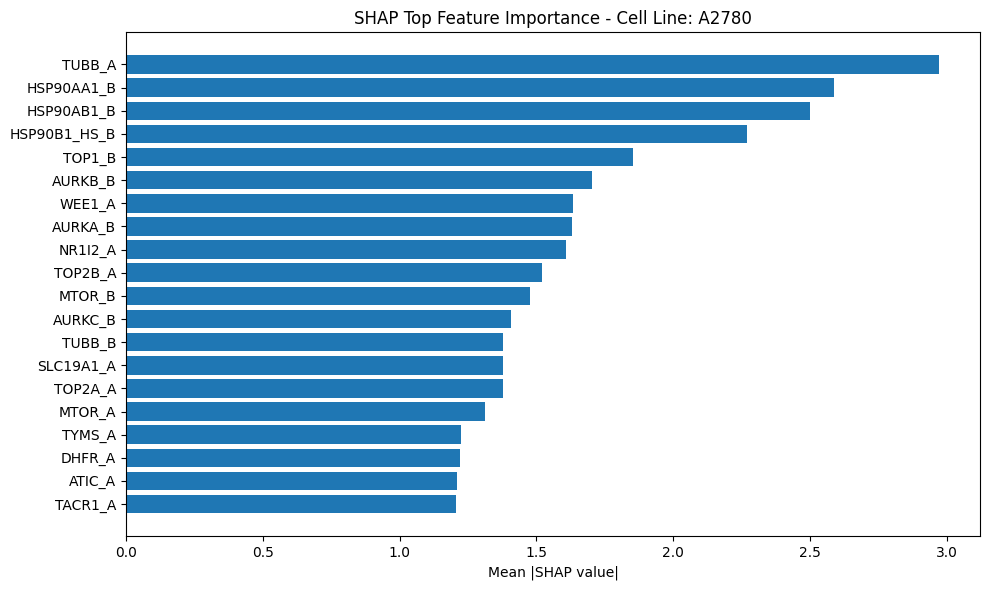

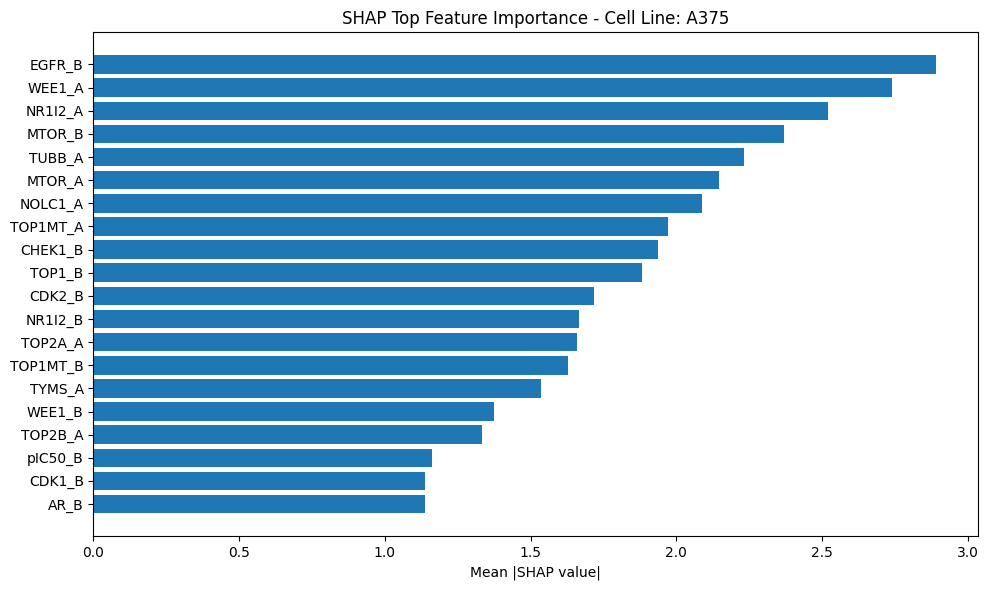

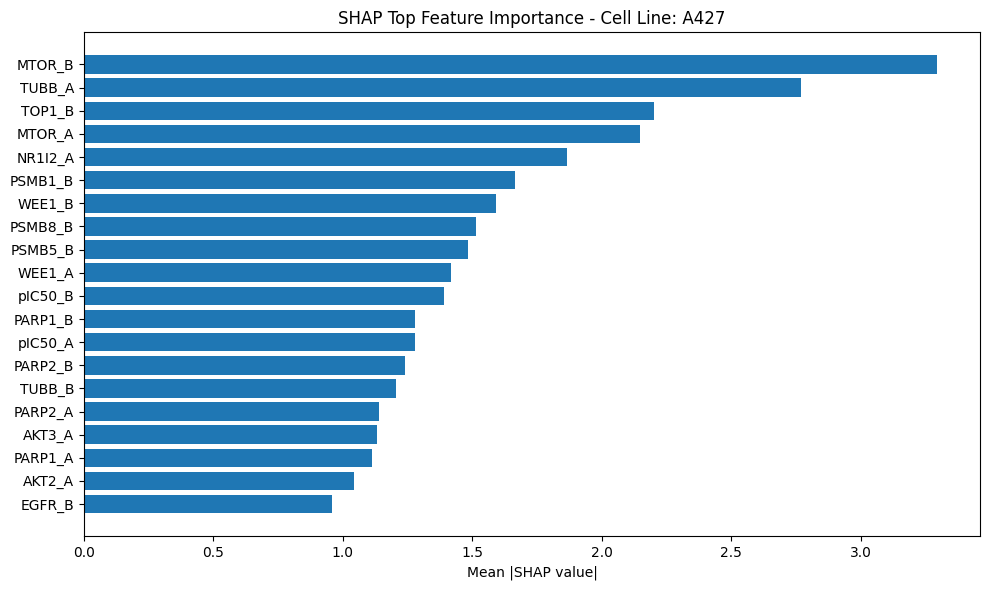

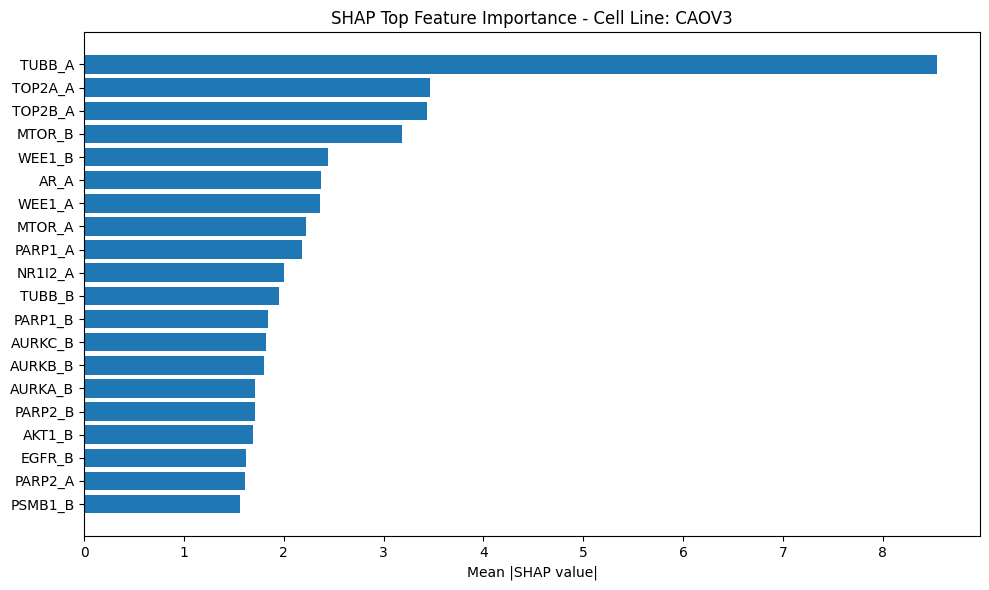

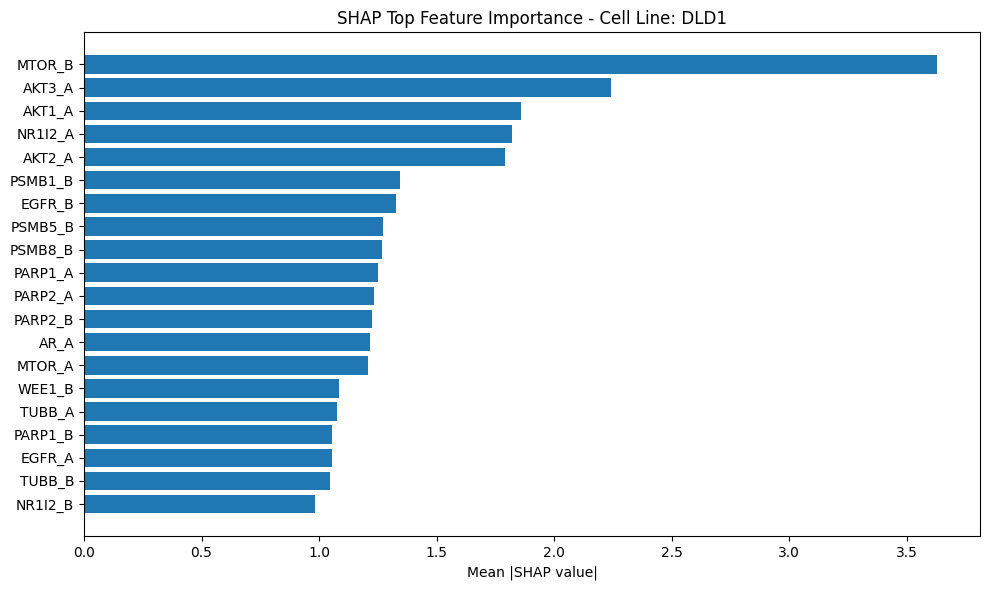

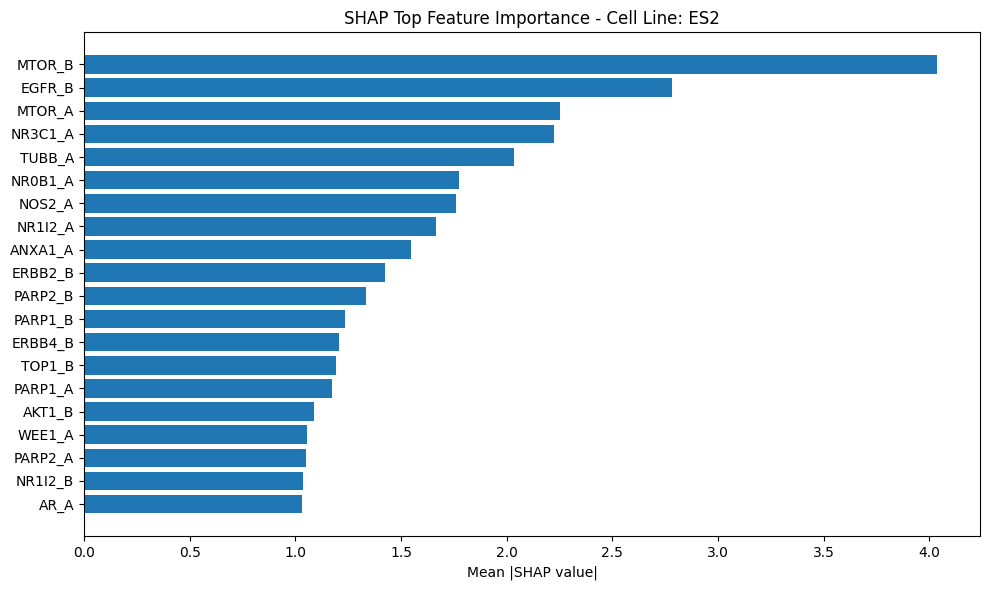

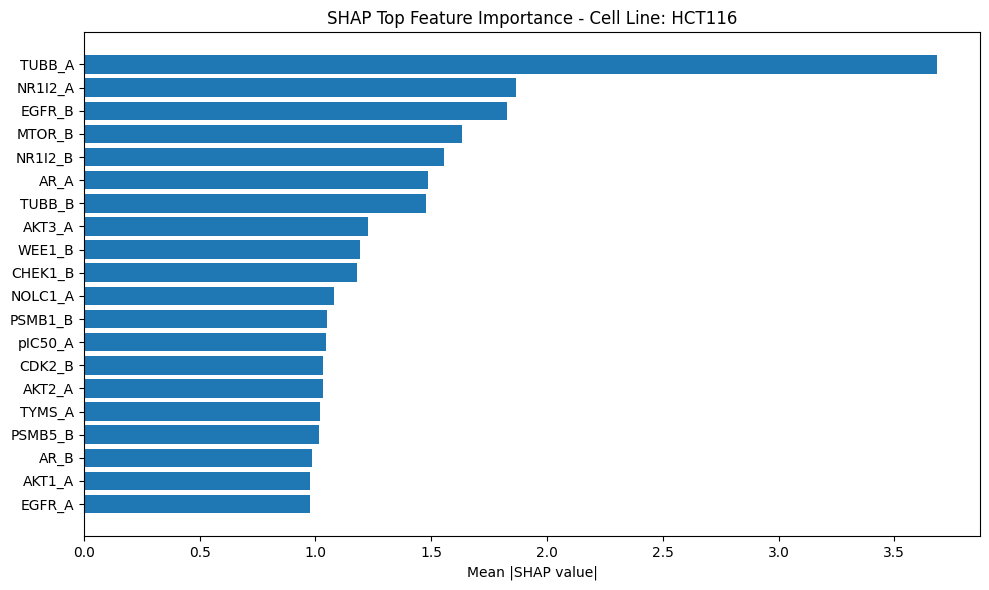

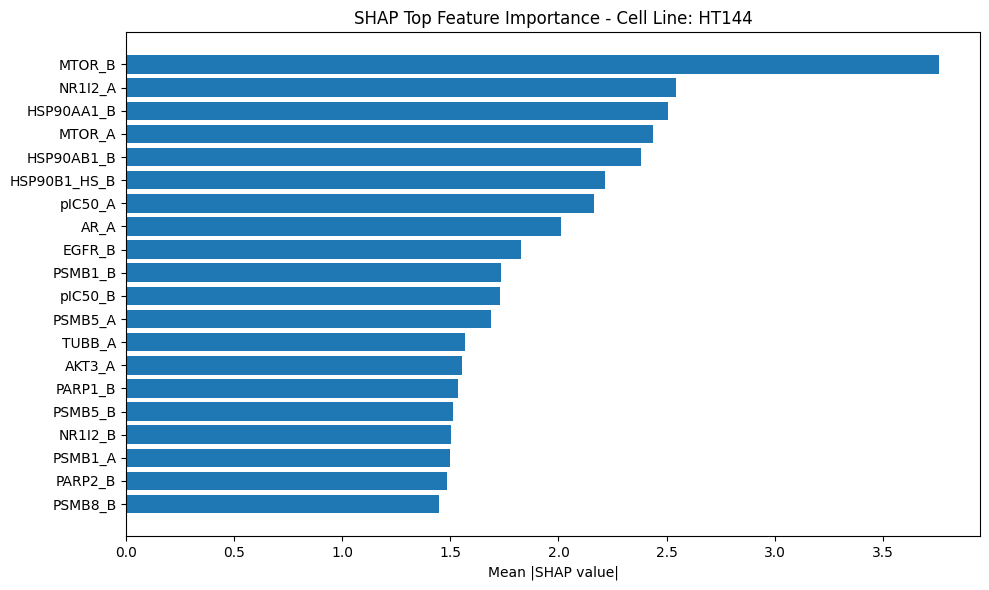

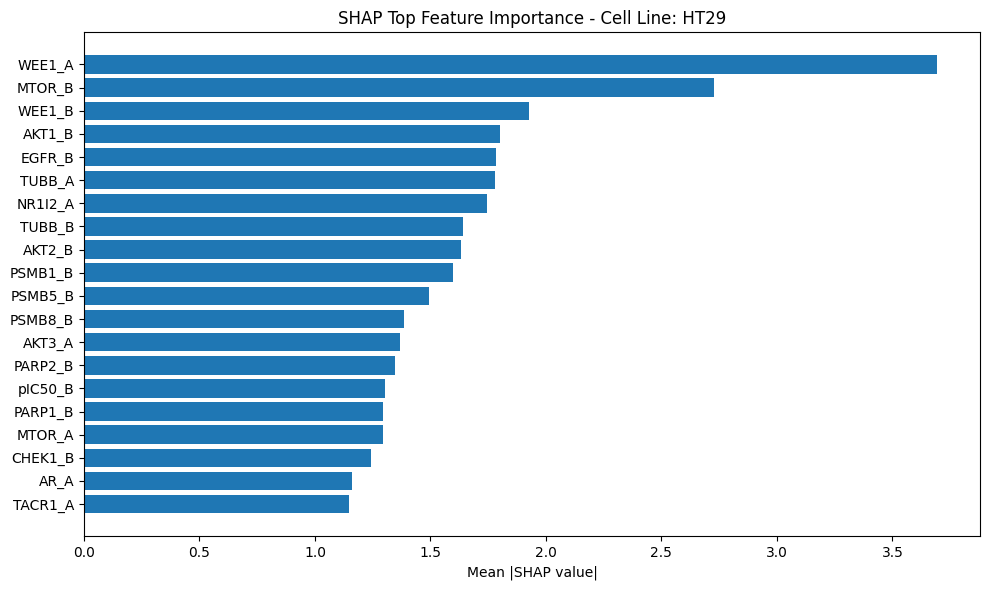

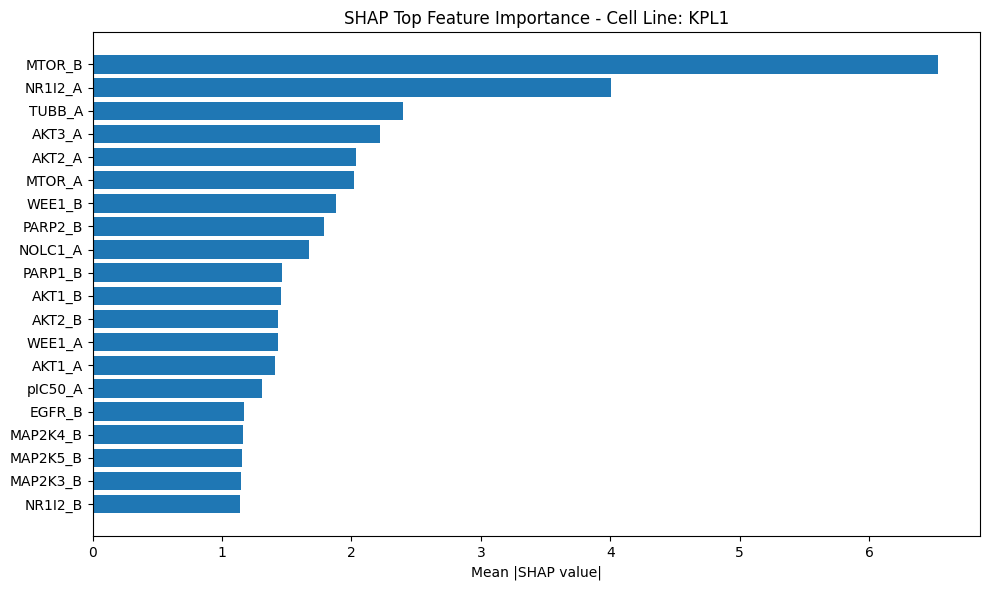

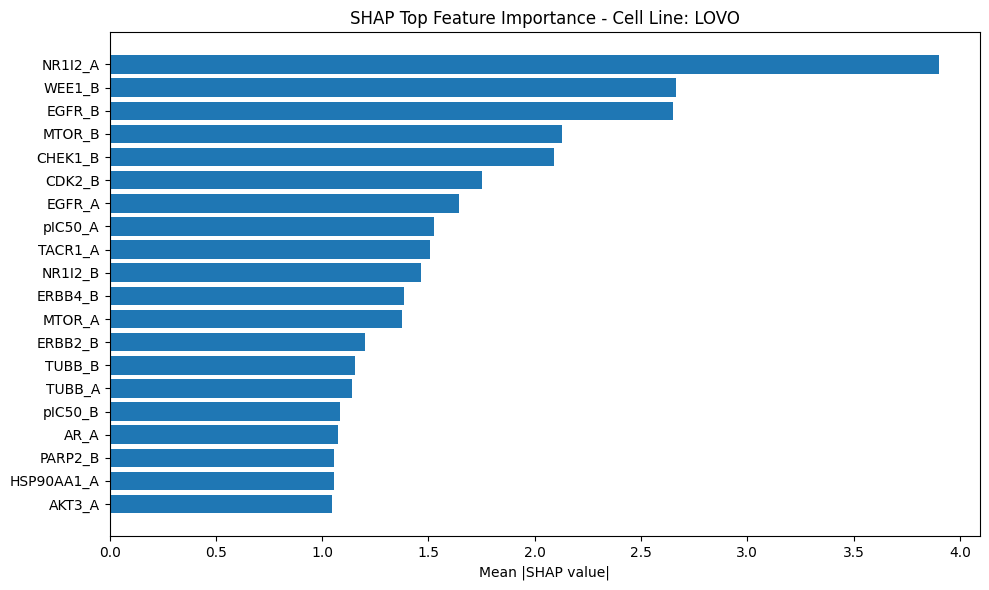

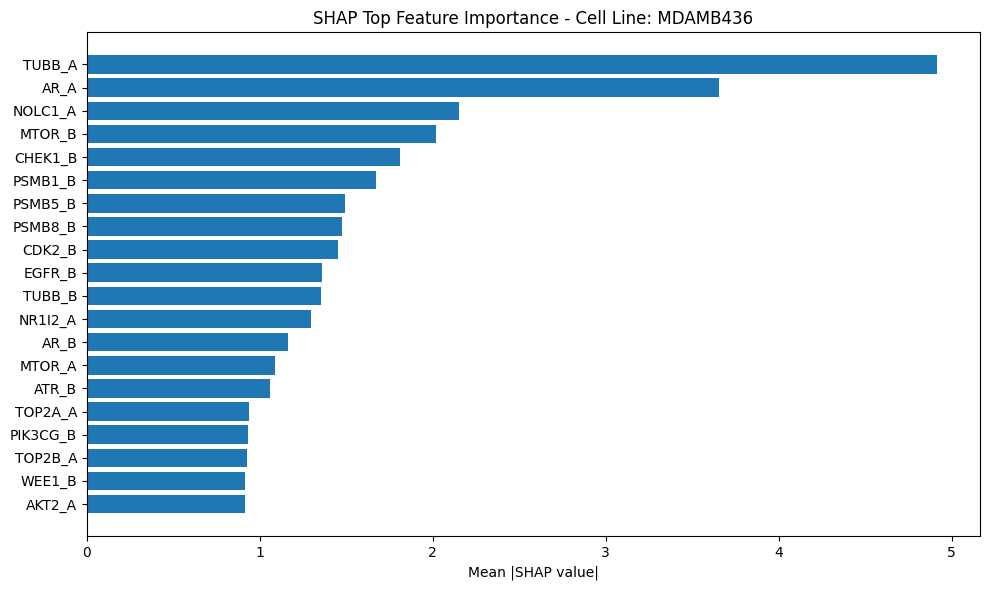

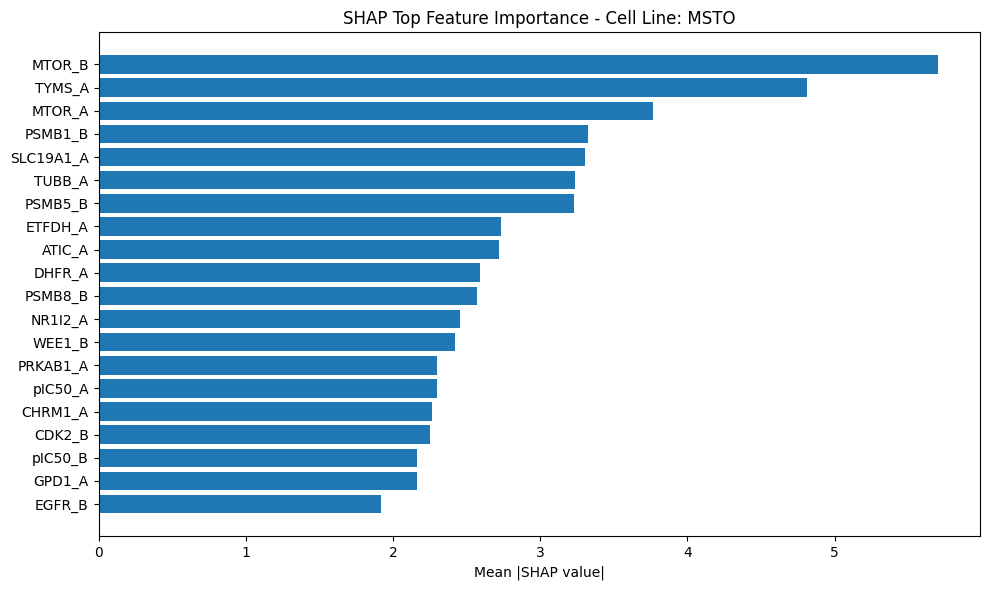

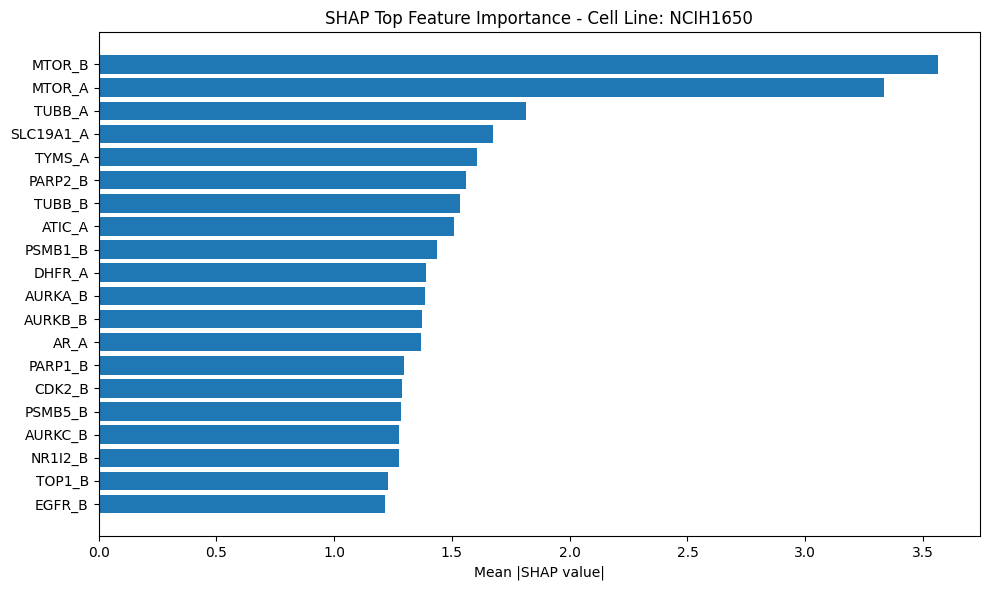

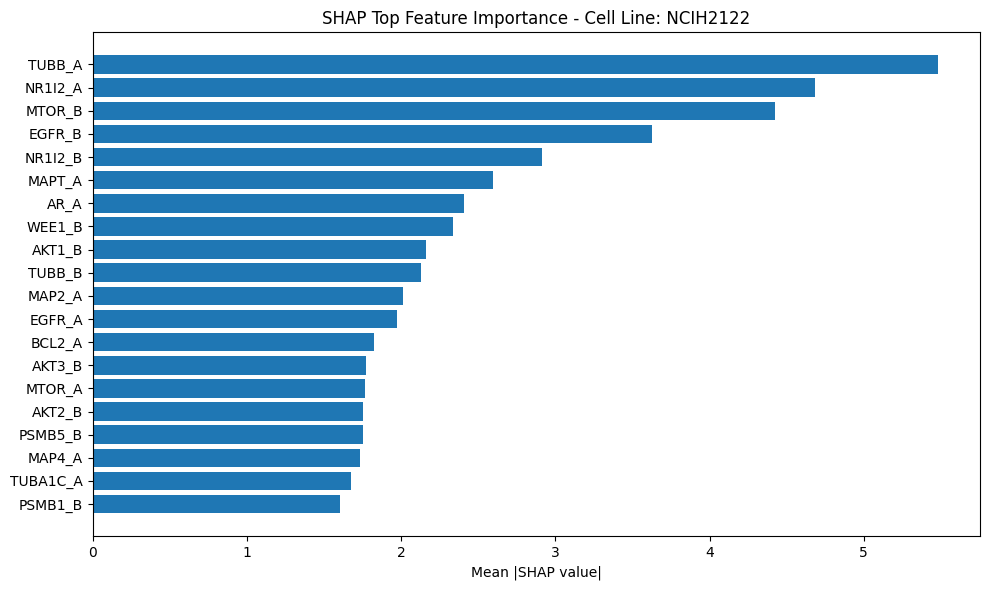

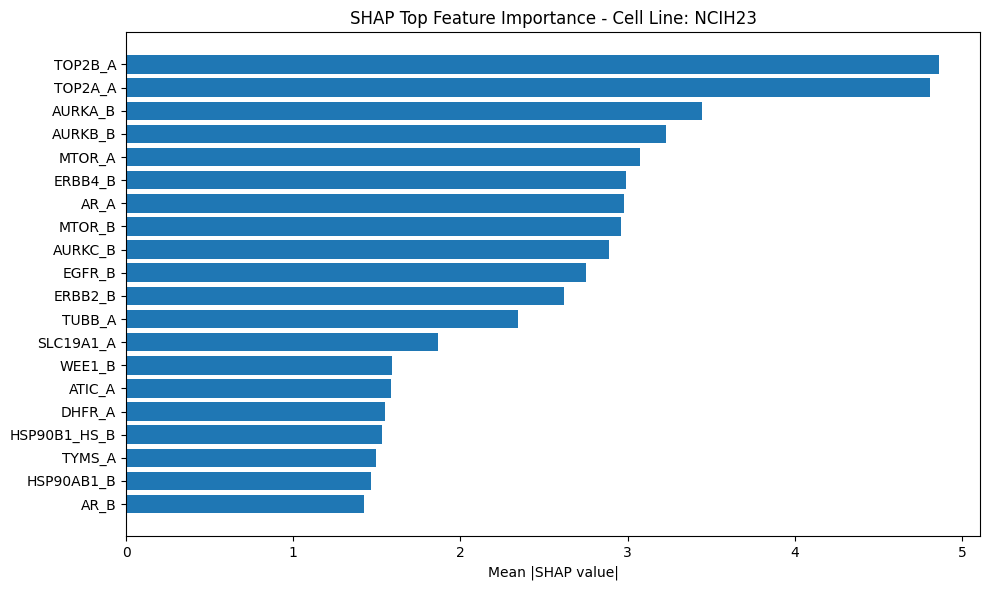

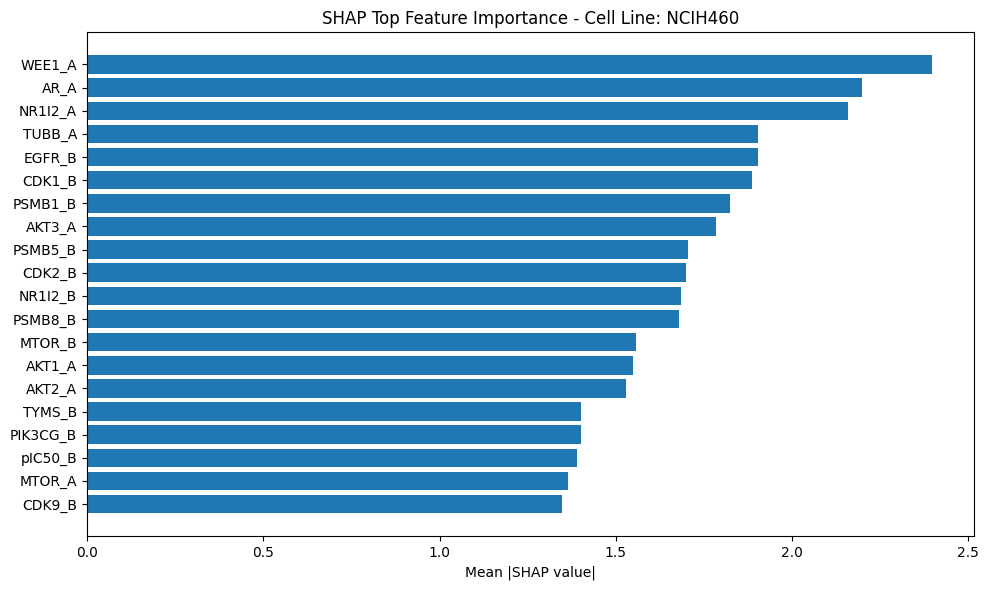

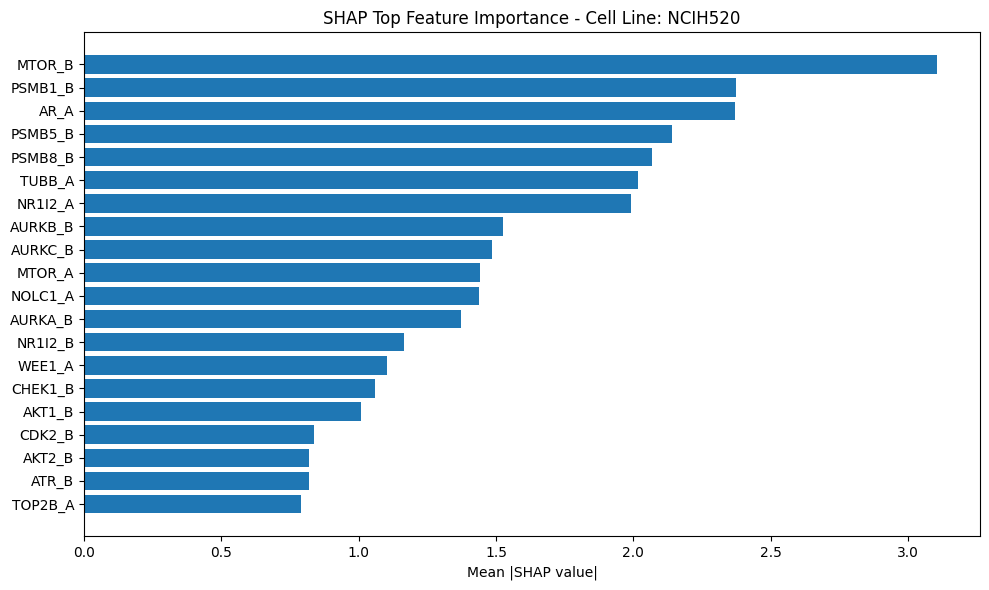

KeyboardInterrupt: 

In [ ]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(shap_values, feature_names, tran_indices, top_n=20):
    cell_lines = load_transynergy_cell_line_data(split='test')
    #only get the cell lines that were used for SHAP
    sampled_cell_lines = np.array(cell_lines)[tran_indices]
    
    unique_cell_lines = np.unique(sampled_cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(sampled_cell_lines == cell_line)[0]
        cell_line_shap_values = shap_values[cell_line_indices]
        
        mean_abs_shap = np.mean(np.abs(cell_line_shap_values), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs_shap
        }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"SHAP Top Feature Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(tran_shap_values, tran_feature_names, tran_indices)

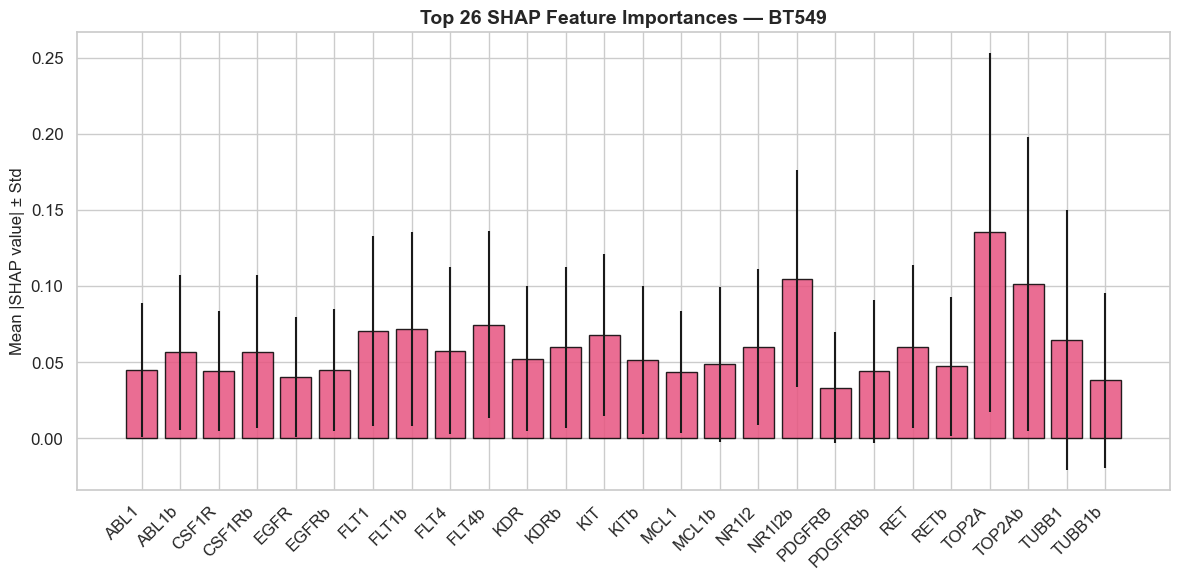

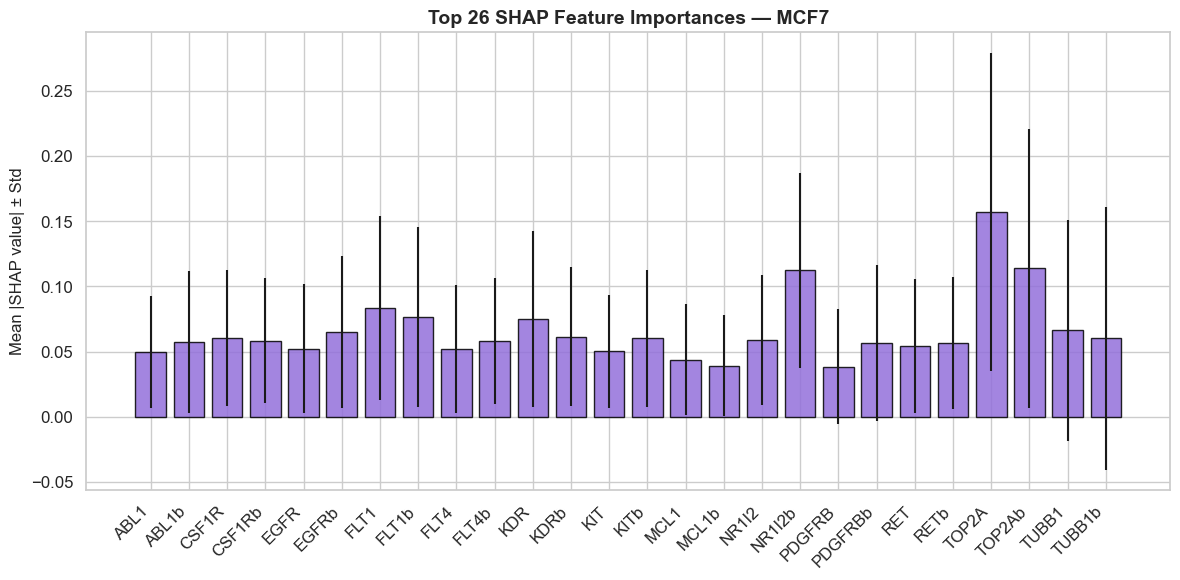

In [ ]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_selected_cell_lines_shap(shap_values, feature_names, bio_indices, top_n=26):
    sns.set(style="whitegrid", font_scale=1.1)
    
    cell_lines = load_biomining_cell_line_data(split='test')
    cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    sampled_cell_lines = cell_lines[bio_indices]

    target_cell_lines = sorted(["MCF7", "BT549"])
    color_map = {
        "MCF7": "#9370DB",  
        "BT549": "#e75480"  
    }

    mask = np.isin(sampled_cell_lines, target_cell_lines)
    filtered_shap_values = shap_values[mask]
    filtered_cell_lines = sampled_cell_lines[mask]

    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        shap_subset = filtered_shap_values[indices]

        shap_subset = shap_subset[:, :-7]
        trimmed_feature_names = feature_names[:-7]

        mean_abs_shap = np.mean(np.abs(shap_subset), axis=0)
        std_abs_shap = np.std(np.abs(shap_subset), axis=0)

        top_indices = np.argsort(mean_abs_shap)[-top_n:]
        top_features = np.array(trimmed_feature_names)[top_indices]
        top_means = mean_abs_shap[top_indices]
        top_stds = std_abs_shap[top_indices]

        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]

        plt.figure(figsize=(12, 6))
        plt.bar(top_features, top_means, yerr=top_stds,
                color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |SHAP value| ± Std", fontsize=12)
        plt.title(f"Top {top_n} SHAP Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_selected_cell_lines_shap(bio_shap_values, bio_feature_names, bio_indices)




# BT549
- breast cancer cell line, not hormone-dependent, known for its aggressive, invasive behavior for growth and used to study drug resistance
- TOP2A - Highest Attribution: essential for DNA replication and cell division, particularly relevant for this type of breast cancer, which often relies on DNA repair deficiencies, has relatively small difference between drug A and b
- NR1I2b - Second Highest Attribution: key regulator of drug metabolism and transport, metabolic modulation importance
- There is very big difference between drug A and B in both of the above mentioned features, maybe shows that only one drug needs to target it, while the other should complement with other stuff
- FLT1 has similar (relatively high) attribution for A and B: controls blood vessel formation, crucial for tumor development, 
- EGFR and PDGFRB have low scores: both are growth factor receptors, likely because the cell line doesn't rely on their signaling for survival or drug response


# MCF-7 
- one of the most widely used breast cancer cell lines and it is hormone-dependent for growth
- TOP2A and TOP2B - Highest attribution: essential for DNA replication and cell division, makes biological sense for hormone-responsive cancer where cell cycle control is crucial
-	NR1I2b - Second highest attribution (key regulator of drug metabolism and transport), likely relates to hormone metabolism but big difference to drug A
- FLT1 has similar (relatively high) attribution for A and B: controls blood vessel formation, crucial for tumor development, 
- MCL1 - lowest attribution: its main role is to prevent cell death, has low importance compared to other hormone-driven pathways but strange


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


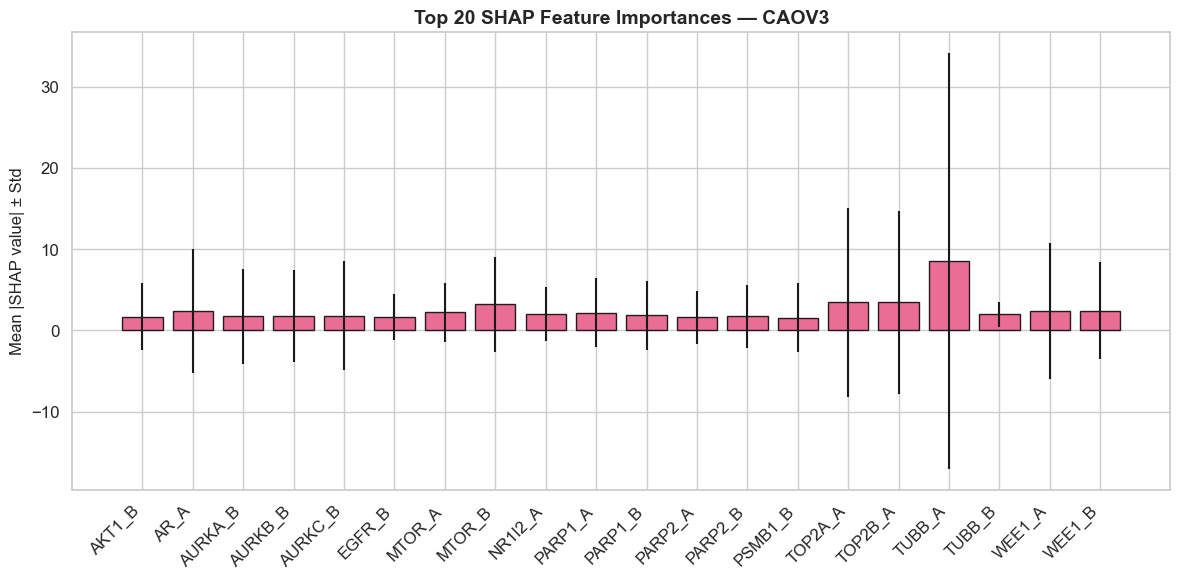

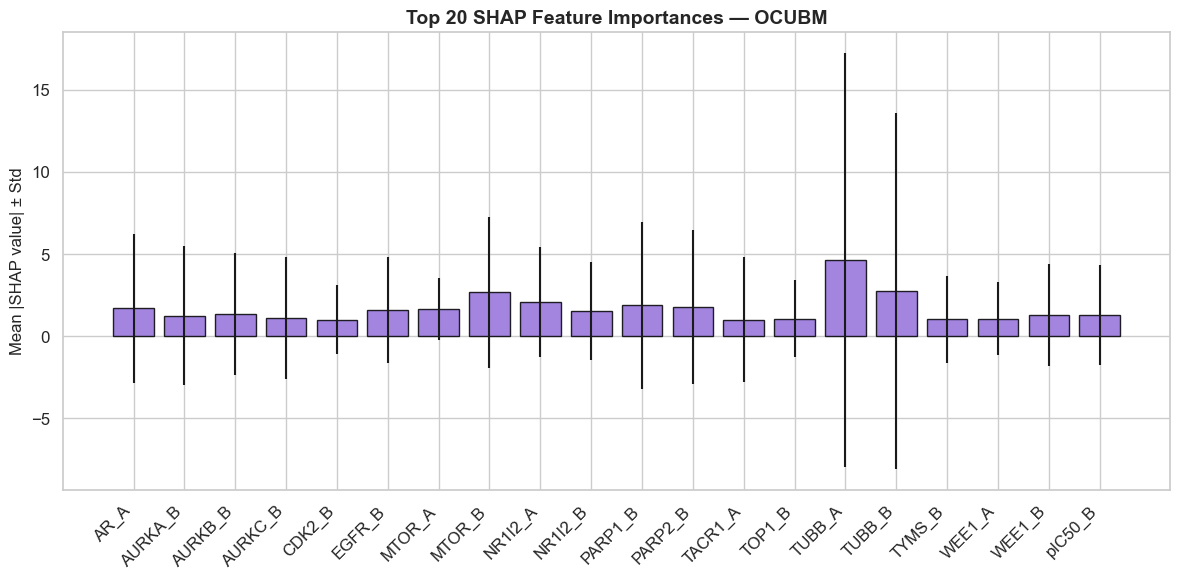

In [9]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_transynergy_shap_by_cell_line(shap_values, feature_names, tran_indices, top_n=20):
    sns.set(style="whitegrid", font_scale=1.1)

    cell_lines = np.array(load_transynergy_cell_line_data(split='test'))
    sampled_cell_lines = cell_lines[tran_indices]

    target_cell_lines = sorted(["CAOV3", "OCUBM"])
    color_map = {
        "CAOV3": "#e75480",  
        "OCUBM": "#9370DB"   
    }

    mask = np.isin(sampled_cell_lines, target_cell_lines)
    filtered_shap = shap_values[mask]
    filtered_cell_lines = sampled_cell_lines[mask]

    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        shap_subset = filtered_shap[indices]

        shap_subset = shap_subset[:, :-2402]
        trimmed_features = feature_names[:-2402]

        mean_abs_shap = np.mean(np.abs(shap_subset), axis=0)
        std_abs_shap = np.std(np.abs(shap_subset), axis=0)

        top_indices = np.argsort(mean_abs_shap)[-top_n:]
        top_features = np.array(trimmed_features)[top_indices]
        top_means = mean_abs_shap[top_indices]
        top_stds = std_abs_shap[top_indices]

        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(top_features, top_means, yerr=top_stds,
                       color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |SHAP value| ± Std", fontsize=12)
        plt.title(f"Top {top_n} SHAP Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_transynergy_shap_by_cell_line(tran_shap_values, tran_feature_names, tran_indices)



# CAOV3
- ovarian cancer cell line 
- TUBB_A - Highest Attribution: its a Tubulin (help maintain cell's shape/ essential cell division), ovarian cancer often shows sensitivity to microtubule-targeting agents like taxanes, very key difference to B counterpart 
- TOP2A_a and _b - second highest, both drugs consistent: essential for DNA replication and cell division, universal importance of DNA damage mechanisms
- MTOR_B also has relatively high attribution: central growth and survival regulator, CAOV3 Not strongly dependent on MTOR mutations.
- PARP2 has low scores: involved in DNA repair but PARP1 may already dominate the DNA repair signal in the model

# OCUMB 
- breast cancer cell line, models triple‑negative metastatic breast cancer (TNBC), a subtype with limited targeted treatment options, serves in studies of metastasis, tumor aggressiveness, and drug sensitivity
- TUBB_A and B - Highest Attribution: its a Tubulin (help maintain cell's shape/ essential cell division), microtubule-targeting drugs are central to TNBC treatment (limited treatment options)
-	MTOR_B third highest attribution: central growth and survival regulator, reflects the importance of PI3K/AKT/mTOR pathway in breast cancer progression
-	PARP1_B and PARP2_B are both similar high: involved in DNA repair, Particularly relevant for breast cancer where PARP inhibitors have shown clinical success, both highlighted
-	TACR1_A lowest attribution: neurotransmission and pain signaling, not relevant for breast cancer
-	CDK2_B lowest attribution as well: involved in cell cycle regulation, surprisingly low importance given CDK's general role in cancer (still in top20)
